## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
#import class from environment file
from TCGame_Env1 import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
import operator

In [2]:
env = TicTacToe()

In [3]:
curr_state = env.state

In [4]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [5]:
Q_state(curr_state)

'x-x-x-x-x-x-x-x-x'

In [6]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [7]:
valid_actions(curr_state)

[(0, 1),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 9),
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 9),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 7),
 (2, 9),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 7),
 (3, 9),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 7),
 (4, 9),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 7),
 (5, 9),
 (6, 1),
 (6, 3),
 (6, 5),
 (6, 7),
 (6, 9),
 (7, 1),
 (7, 3),
 (7, 5),
 (7, 7),
 (7, 9),
 (8, 1),
 (8, 3),
 (8, 5),
 (8, 7),
 (8, 9)]

In [8]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

### Epsilon-greedy strategy 

#### Epsilon - decay check

In [9]:
max_epsilon = 1.0
min_epsilon = 0.001
episodesNum = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.0000015*i))

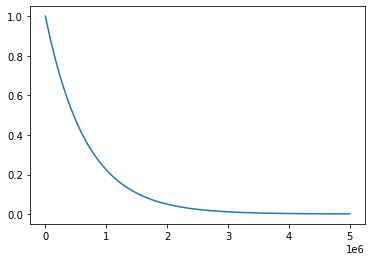

In [10]:
plt.plot(episodesNum, epsilon)
plt.show()

-0.0000015 decay rate is giving a nice decay graph. I plan to train the model for 5 Million episodes so we will try the same decay rate there too

In [11]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    ## First we randomize a number
    exp_exp_tradeoff = random.uniform(0, 1)
        
    ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
    if exp_exp_tradeoff > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)
    # Else doing a random choice --> exploration
    else:
        action_space = [i for i in env.action_space(state)[0]]        
        action = action_space[np.random.choice(range(len(action_space)))]
    
    return action

#### Tracking the state-action pairs for checking convergence

In [12]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [13]:
# Initialise states to be tracked
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(2, 9)),('x-1-x-x-4-x-x-x-x',(7,7)), ('1-x-x-x-4-x-x-x-x',(7,7)),
                       ('x-1-6-x-x-x-x-x-x',(0, 9)),('x-x-9-x-x-6-x-x-x',(7, 7)), ('1-x-x-x-x-x-8-x-x',(7,7)), 
                     ('x-1-x-x-x-x-2-x-x',(2, 3)), ('8-1-x-x-x-x-x-x-x',(2, 9)), ('1-x-x-x-x-4-x-x-x',(2, 9))]
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [14]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [15]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

#### Define hyperparameters

In [16]:
EPISODES = 5000000
LR = 0.01                   # learning rate
GAMMA = 0.9                # discount factor

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.0000015         # epsilon decay rate
threshold = 2000       # no of episodes after which states_tracked wwill be saved

### Q-update loop

In [17]:
#initialising the states tracking once before the loop
initialise_tracking_states()
start_time = time.time()
rewards = [] #for tracking rewards to check model improvement
for episode in range(EPISODES):
    env = TicTacToe() # call the environment
    curr_state = env.state    
    done = False  
    add_to_dict(curr_state)  # adding the current state to dictionary
    total_reward = 0
    while done != True:  
        curr_state1 = Q_state(curr_state)
        #print(curr_state1)
        curr_action = epsilon_greedy(curr_state, episode)   # applying epislon method
        next_state, reward, done = env.step(curr_state, curr_action) # getting rewar
        next_state_temp = Q_state(next_state)
        add_to_dict(next_state)
        #print(next_state, reward, done)

        # Updating rules
        if done != True:
            max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)  
                #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_temp][max_next])))
                                                      - Q_dict[curr_state1][curr_action] ) 
        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))

        # navigating to next state
        curr_state = next_state
        total_reward += reward
    
    if ((episode+1)%threshold)==0:
        save_tracking_states()
    
    rewards.append(total_reward)
    print('Progress: '+ str(round(episode/EPISODES*100,2)) + '%',  end='\r')

#we are saving the policy and states tracking in the pickle file only once at the end to reduce 
#for performance    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

In [18]:
#Total time taken to train the model (depends on machine power)
print(str(elapsed_time/60) + ' minutes')

91.39239913225174 minutes


#### Plotting Model Improvement over time(episodes):

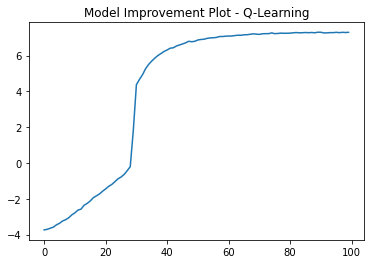

In [19]:
rewards_arr = np.array(rewards)
n = rewards_arr.size
rew_arr_new = rewards_arr[:(n // 100) * 100].reshape(100, -1) #converting the rewards to (100, 50000)
y = rew_arr_new.mean(axis = 1) #taking mean of every 50k records
plt.title("Model Improvement Plot - Q-Learning")
plt.plot(y)

##### We can see that the model keeps improving over time with bad average rewards in the beginning and last 50k records gave average reward of more than 6

#### Check the Q-dictionary

In [20]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.3141579342648477,
              (0, 3): -1.3077836369633318,
              (0, 5): -1.3351631583490389,
              (0, 7): -1.3218476421954488,
              (0, 9): -1.3212889094797762,
              (1, 1): -1.2236801479346708,
              (1, 3): -1.324868434279479,
              (1, 5): -1.3310619568859803,
              (1, 7): -1.3008367126205331,
              (1, 9): -1.3223150557913022,
              (2, 1): -1.33048705441437,
              (2, 3): -1.315807687990758,
              (2, 5): -1.345626753501516,
              (2, 7): -1.3278331110384627,
              (2, 9): -1.3152578596803441,
              (3, 1): -1.3288834706055765,
              (3, 3): 5.410930357619382,
              (3, 5): -1.3335409770889184,
              (3, 7): -1.3223699605827801,
              (3, 9): -1.3332064798224896,
              (4, 1): -1.3435592542049049,
              (4, 3): -1.3384965393947172,
              (4, 5): 

In [21]:
len(Q_dict)

2009797

In [22]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
print(max(Q_dict['x-x-x-x-x-x-x-x-x'].items(), key=operator.itemgetter(1))[0], 'is the best action for state initial state x-x-x-x-x-x-x-x-x') 

(3, 3) is the best action for state initial state x-x-x-x-x-x-x-x-x


#### Check the states tracked for Q-values convergence
(non-evaluative)

In [23]:
States_track

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(2, 9): [-0.3764746051087998,
               -0.6302703623502736,
               -0.7450902393036904,
               -0.8410572908002124,
               -0.8998941257385105,
               -0.9316722755352883,
               -0.9582437496415632,
               -0.9723455852887762,
               -0.9832689113165723,
               -0.9885801185396002,
               -0.9925873249283991,
               -0.9951884131277832,
               -0.9971468904308294,
               -0.9981665586888322,
               -0.9987978872989514,
               -0.9991372070108334,
               -0.99949857369236,
               -0.9996577491696612,
               -0.9997800656456011,
               -0.9998669383812168,
               -0.9999100863988732,
               -0.9999444972204877,
               -0.999965392607487,
               -0.9999788508258203,
               -0.9999858517997569,
               -0.9999902455362758,
               -0.99

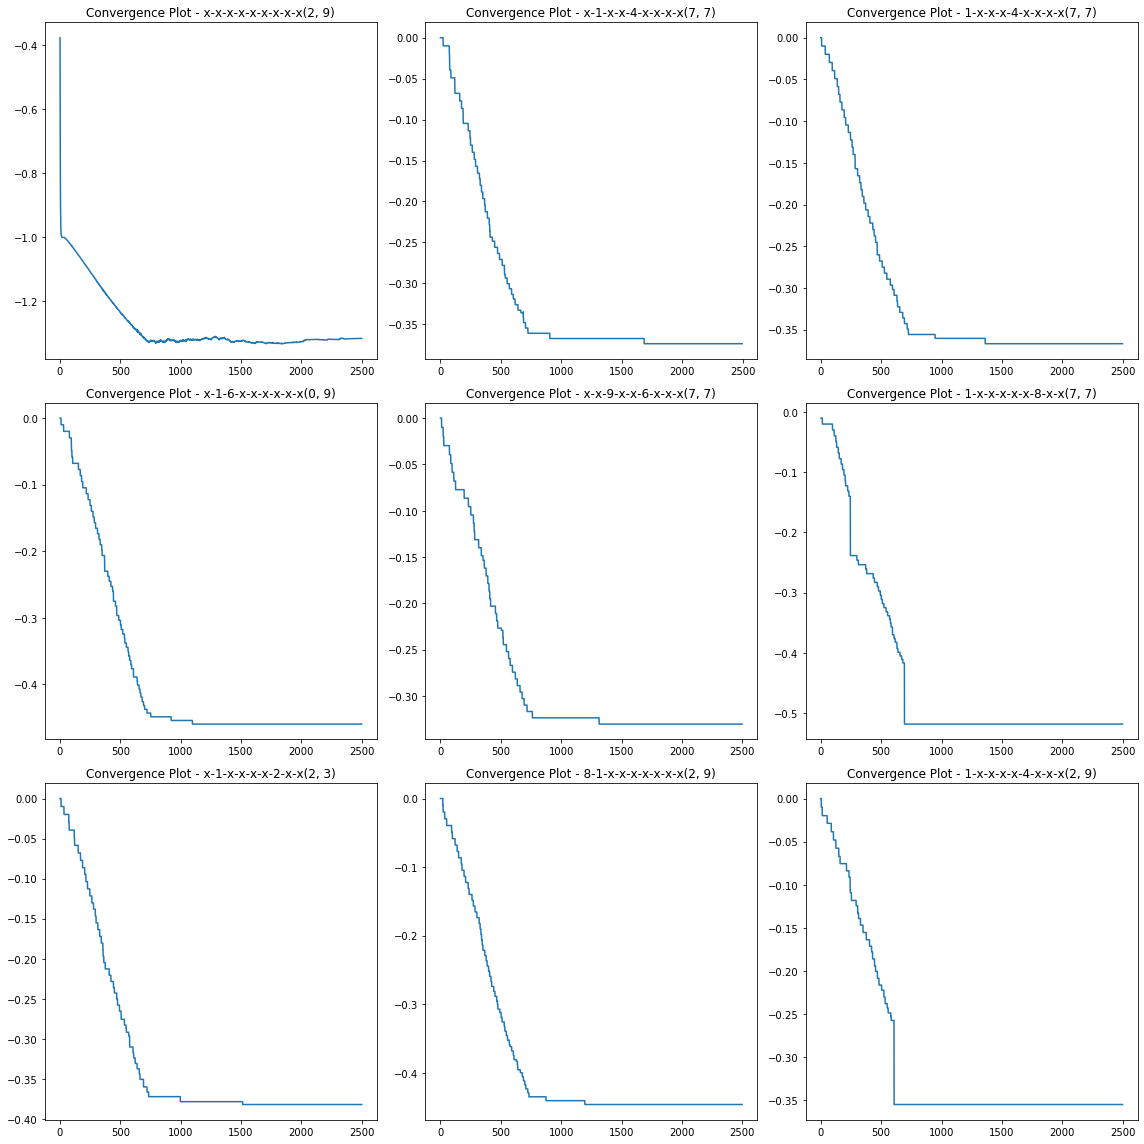

In [24]:
# Write the code for plotting the graphs for state-action pairs tracked
i=1
plt.figure(figsize=(16, 16))
for state in States_track.keys():
    for action in States_track[state].keys():
        plt.subplot(3, 3, i)
        plt.plot(States_track[state][action], label=state)
        #plt.legend()
        plt.title("Convergence Plot - " + state + str(action))
        plt.tight_layout()
        i+=1

#### Verification of States Tracking pickle file

In [25]:
with open('States_tracked.pkl', 'rb') as handle:
    States_tracked_pkl = pickle.load(handle)

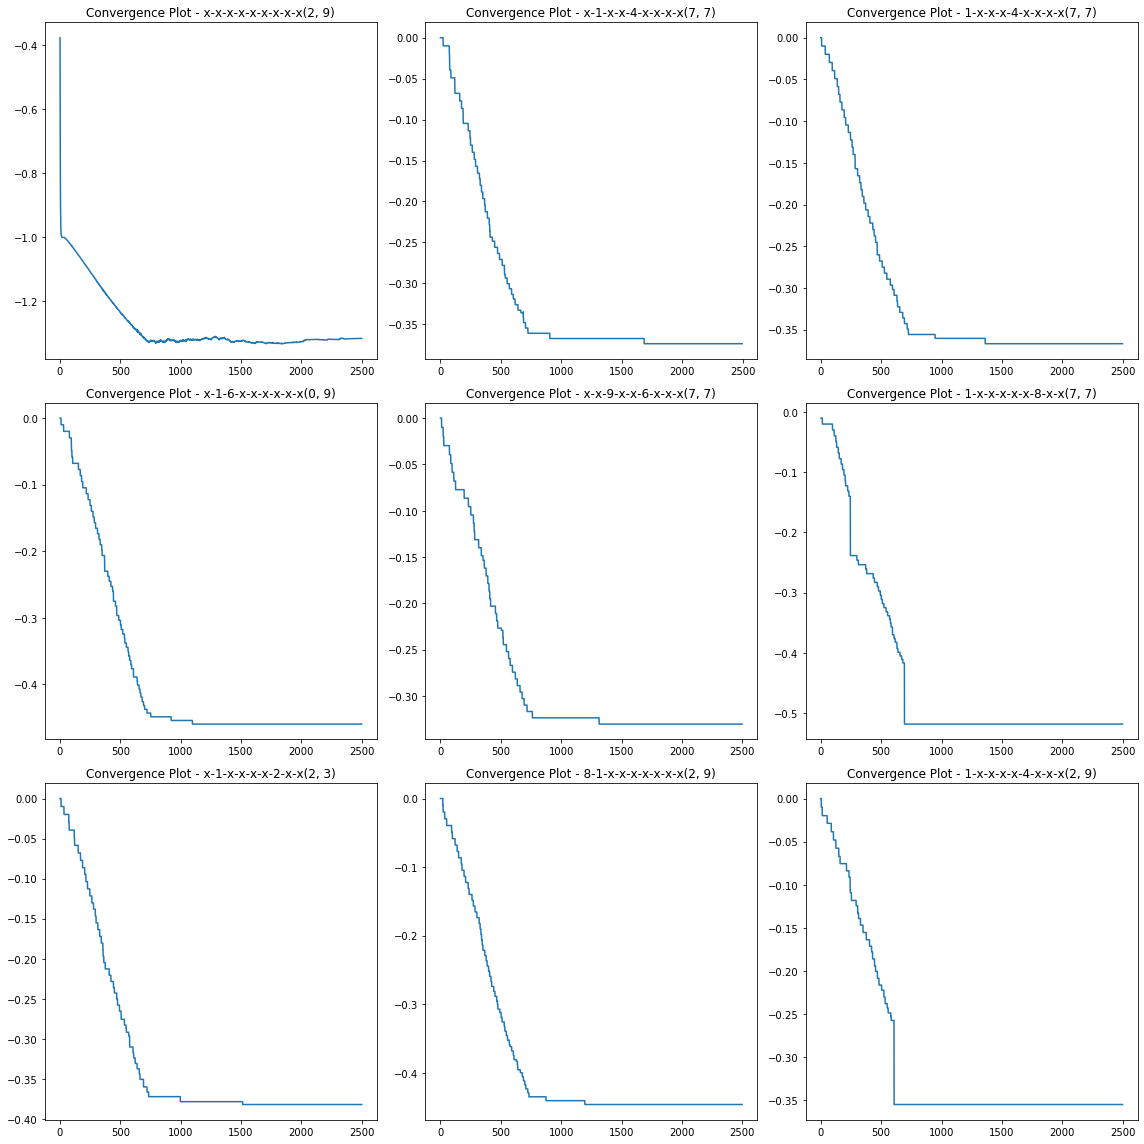

In [26]:
# Write the code for plotting the graphs for state-action pairs tracked
i=1
plt.figure(figsize=(16, 16))
for state in States_tracked_pkl.keys():
    for action in States_tracked_pkl[state].keys():
        plt.subplot(3, 3, i)
        plt.plot(States_tracked_pkl[state][action], label=state)
        #plt.legend()
        plt.title("Convergence Plot - " + state + str(action))
        plt.tight_layout()
        i+=1

# Win% of the Agent over 100k games

In [27]:
#best state action pairs
TOTAL_GAMES = 100000
win_count = 0
env = TicTacToe()
state_game = env.state  
for episode in range(TOTAL_GAMES):
    env = TicTacToe()
    state = env.state  
    step = 0
    done = False

    while done!=True:
        
        action = max(Q_dict[Q_state(state)].items(), key=operator.itemgetter(1))[0]
        next_state, reward, done = env.step(state, action)            

        state = next_state
    if reward==10:
        win_count+=1
print('Winning accuracy: ' + str(win_count/TOTAL_GAMES))

Winning accuracy: 0.96319


## Sample game played by the agent

In [28]:

env = TicTacToe()
state_game = env.state  

for episode in range(1):
    env = TicTacToe()
    state = env.state  
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)

    while done!=True:
        
        action = max(Q_dict[Q_state(state)].items(), key=operator.itemgetter(1))[0]
        
        next_state, reward, done = env.step(state, action)
        
        board = np.array(state).reshape(3,3)

        print('\n'.join('\t'.join('{:3}'.format(item) for item in row) for row in board))
        print('------------------------------------------------')
            
            

        state = next_state
if reward==10:        
    print('WIN' + '!!!')

****************************************************
EPISODE  0
nan	nan	nan
3.0	nan	nan
nan	nan	6.0
------------------------------------------------
nan	nan	nan
3.0	8.0	nan
7.0	nan	6.0
------------------------------------------------
1.0	nan	nan
3.0	8.0	nan
7.0	nan	6.0
------------------------------------------------
WIN!!!
